# **CIS 520: Machine Learning, Fall 2020**
# **Week 11, Worksheet 1**
## **Naive Bayes**


- **Content Creator:** Margaret Ji
- **Content Checkers:** Gautam Ramesh, Yang Yan
- This worksheet is partially **adapted** from: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb#scrollTo=LOj40WjbveIX

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.

Imagine that you have the following data:

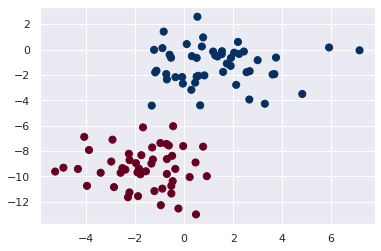

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. That is, the featurs are mutually independent.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.

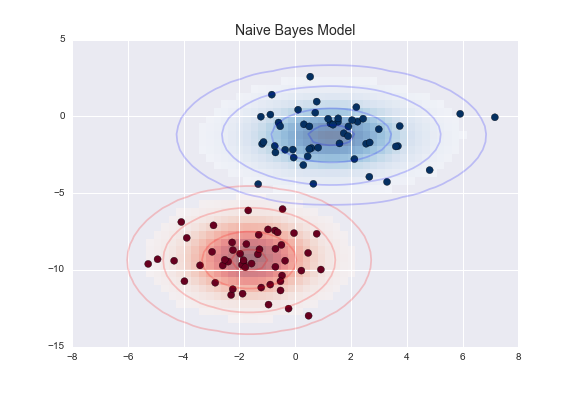

The following codes simply calculate the sample mean and standard deviation of the data for x- and y-dimension, for each (red/blue) category.

[(-15.0, 5.0), (-8.0, 8.0)]

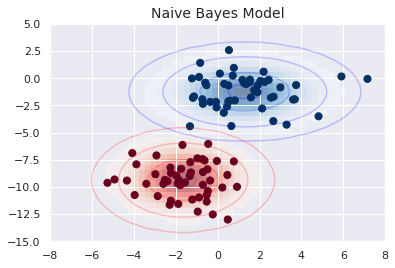

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

# fig.savefig('figures/05.05-gaussian-NB.png')

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~\mu_1, \sigma_1),P({\rm features}~|~\mu_2, \sigma_2)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [ ]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

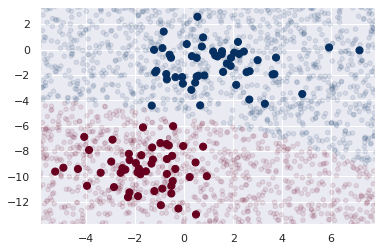

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [ ]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second label, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [ ]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer (discussed in [Feature Engineering](05.04-Feature-Engineering.ipynb)). The (i,j) entry of the resulting vectorized matrix represented the j-th term's number of times occuring in the i-th document, weighted by the inverse document frequency: $\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}$, where $N$ is the number of documents, and  $|\{d \in D: t \in d\}|$ is the number of documents where the term ${\displaystyle t}$ appears.


We create a pipeline that first does the vectorization of the text to a $tf-idf$ matrix, and thenn attaches it to a multinomial naive Bayes classifier:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0))

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [ ]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


We can also look at the estimated prior for the model: $P[c_j]$

In [ ]:
model[1].class_log_prior_

array([-1.30471651, -1.2894231 , -1.2793559 , -1.74237231])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

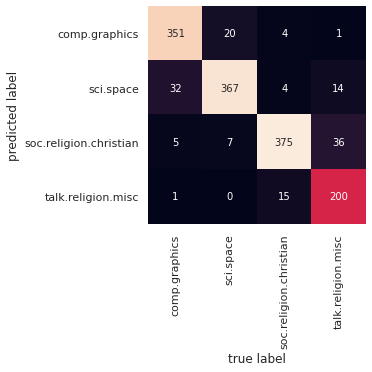

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can also look at the mean accuracy of the prediction:

In [ ]:
model.score(test.data, test.target)

0.9029329608938548

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [ ]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [ ]:
predict_category('sending a payload to the ISS')

'sci.space'

In [ ]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [ ]:
predict_category('x##@2dfgf@f5!!!!3vs')

'comp.graphics'

In [ ]:
model.predict_proba(['x##@2dfgf@f5!!!!3vs'])
# predict_category()

array([[9.99999996e-01, 1.31751107e-09, 1.21012786e-09, 1.25803455e-09]])

array([-1.30471651, -1.2894231 , -1.2793559 , -1.74237231])

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

#### Example contiued: Laplace smoothing
Let's reprocess the data using additive smoothing, and see whether the performance improve.
- adjust $\alpha$. When $\alpha=1$, it is Laplace smoothing

Without smoothing, the probability of a vocabulary $x_i$ conditioned on a category $c_j$ is simply $P[x_i|c_j] = \frac{x_i\text{'s number of appearances in documents of }c_j}{\text{total number of words in documents of }c_j}$. However, if a vocabulary has never appeared in the training data, this probability is simply 0. 

Instead, Laplace smoothing does the following:

$P[x_i|c_j] = \frac{x_i\text{'s number of appearances in documents of }c_j + 1}{\text{total number of words in documents of }c_j + \text{size of the vocabulary}}$



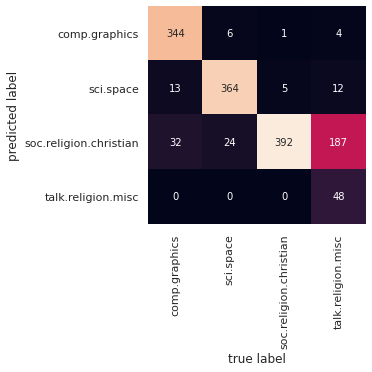

In [ ]:
model_l = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1))
model_l.fit(train.data, train.target)
labels_l = model_l.predict(test.data)
mat = confusion_matrix(test.target, labels_l)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
model_l.score(test.data, test.target)

0.8016759776536313

#### Example contiued: text classification using logistic regression

Alternatively, we can also use logistic regression for the task of multiclass classification. We use the same $tf-idf$ matrix.


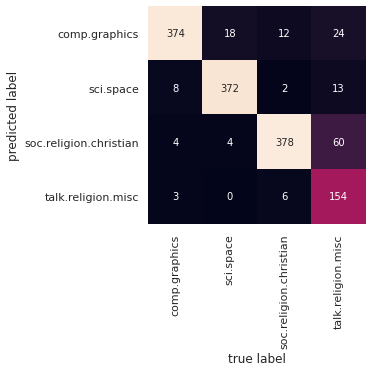

In [ ]:
from sklearn.linear_model import LogisticRegression
model_reg = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_reg.fit(train.data, train.target)
labels_reg = model_reg.predict(test.data)
mat = confusion_matrix(test.target, labels_reg)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
model_reg.score(test.data, test.target)

0.8924581005586593

### LDA
- Instead assigning exactly one category to a document like Naive Bayes, LDA models each document containing a mixture of categories.  
- For each document, LDA assigns probabilities to each category.
- Questions to think about: 
  - Why does LDA not take in y values when fitting the model?
  - For the same data, is LDA a good model for predicting categories? (Notice that we already know the categories here.)
  - What will be a good scenario where LDA will be a better model than Naive Bayes?






In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = make_pipeline(CountVectorizer(), LatentDirichletAllocation(n_components=4, random_state=0))
lda.fit(train.data)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                ('latentdirichletallocation',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='batch',
                

Beware that even though we specified 4 categories for the LDA model, we did NOT say which topic is which. However, looking at the confusion matrix, we see that it is able to distinguish the differences between the categories by a great extend.

In [ ]:
def predict_category_lda(test_data, model):
  transform = model.transform(test_data)
  y_pred = np.argmax(transform, axis=1)
  return y_pred

In [ ]:
y_pred = predict_category_lda(test.data, lda)

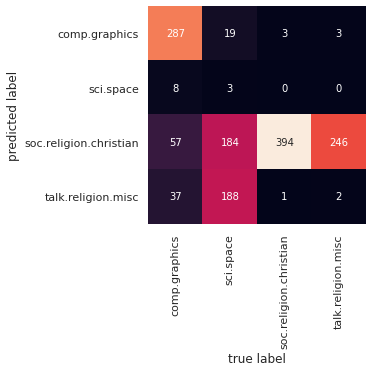

In [ ]:
mat = confusion_matrix(test.target, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');